# NB01: TF-IDF + Linear Models -- Baselines that Win

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RJuro/unistra-nlp2026/blob/main/notebooks/NB01_tfidf_baselines.ipynb)

---

**Learning Goals**

By the end of this notebook you will be able to:

- **Build a complete text classification pipeline** from raw text to predictions using scikit-learn
- **Understand TF-IDF** -- how term frequency and inverse document frequency turn words into numbers
- **Evaluate models** with confusion matrices and classification reports (precision, recall, F1)
- **Analyze errors** -- the single most important skill for improving any NLP system

**Estimated time:** ~90 minutes

---

In [1]:
# ── Setup ────────────────────────────────────────────────────────────
# Install dependencies (Colab-friendly)
!pip install scikit-learn pandas numpy matplotlib seaborn -q

# Core
import pandas as pd
import numpy as np
import json
import re
import warnings

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

print("All imports successful.")

All imports successful.


## 1. The Dataset

We will work with **dk_posts** -- a collection of **457 synthetic Danish Reddit advice posts** that have been translated into English and labelled into **8 categories**:

| Category | Description |
|---|---|
| Love & Dating | Romantic relationships and dating |
| Family Dynamics | Issues with parents, siblings, relatives |
| Friendship & Social Life | Making/keeping friends, social anxiety |
| Work, Study & Career | Jobs, education, career decisions |
| Health & Wellness (Physical and Mental) | Physical and mental health concerns |
| Personal Finance & Housing | Money, rent, budgeting |
| Everyday Observations & Rants | General complaints and observations |
| Practical Questions & Everyday Life | How-to questions, daily life tips |

This dataset is our **running example for NB01 through NB03**. It is small enough to iterate quickly, yet diverse enough to show real classification challenges.

In [2]:
# ── Load data from GitHub ────────────────────────────────────────────
DATA_URL = "https://raw.githubusercontent.com/RJuro/unistra-nlp2026/main/data/dk_posts_synth_en_processed.json"

df = pd.read_json(DATA_URL)

print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print()
display(df.head())

print("\n── Label distribution ──")
print(df["label"].value_counts())

Shape: (457, 3)
Columns: ['title', 'selftext', 'label']



,title,selftext,label
0,Partner won't meet my friends,Hey Brevkasse. I've been with my boyfriend for...,Love & Dating
1,My sister copies everything I do,My little sister (22) has started to imitate m...,Family Dynamics
2,Feeling overlooked at my new student job,"I started a new student job a month ago, and I...","Work, Study & Career"
3,How do you make new friends as an adult?,I moved to a new city half a year ago because ...,Friendship & Social Life
4,Constant headache - the doctor says it's stress,Hi everyone. The last three months I've had he...,Health & Wellness (Physical and Mental)



── Label distribution ──
Family Dynamics                            63
Love & Dating                              60
Work, Study & Career                       58
Friendship & Social Life                   58
Health & Wellness (Physical and Mental)    56
Everyday Observations & Rants              55
Practical Questions & Everyday Life        54
Personal Finance & Housing                 53
Name: label, dtype: int64


## 2. Text Preprocessing

Before we can classify posts, we need to prepare the text:

1. **Combine title + body** -- many posts carry important signal in both the title and the selftext. We join them with a period separator so the vectorizer sees one coherent document.
2. **Basic cleaning** -- lowercase everything and collapse extra whitespace. We intentionally keep it minimal: TF-IDF with stop-word removal already handles most noise, and aggressive cleaning (stemming, lemmatization) often hurts more than it helps for short social-media text.

In [3]:
# ── Combine title + selftext ─────────────────────────────────────────
df["text"] = df["title"] + " . " + df["selftext"]


# ── Simple cleaning function ─────────────────────────────────────────
def clean_text(text: str) -> str:
    """Lowercase, strip, and collapse whitespace."""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()


df["text_clean"] = df["text"].apply(clean_text)

# ── Before / after example ───────────────────────────────────────────
idx = 0
print("BEFORE cleaning:")
print(df.loc[idx, "text"][:200])
print()
print("AFTER cleaning:")
print(df.loc[idx, "text_clean"][:200])

BEFORE cleaning:
Partner won't meet my friends . Hey Brevkasse. I've been with my boyfriend for almost a year, and he still hasn't met my friends. Every time I suggest it, he comes up with an excuse. My friends have s

AFTER cleaning:
partner won't meet my friends . hey brevkasse. i've been with my boyfriend for almost a year, and he still hasn't met my friends. every time i suggest it, he comes up with an excuse. my friends have s


## 3. Train/Test Split

We hold out **25 %** of the data for evaluation. The `stratify` parameter ensures that every class keeps roughly the same proportion in both the training and test sets -- essential when some categories are smaller than others.

In [4]:
# ── Stratified 75/25 split ───────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"],
    df["label"],
    test_size=0.25,
    stratify=df["label"],
    random_state=42,
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")
print(f"Number of classes: {y_train.nunique()}")

Training samples: 342
Test samples:     115
Number of classes: 8


## 4. TF-IDF + Logistic Regression

### What is TF-IDF?

**TF-IDF** (Term Frequency -- Inverse Document Frequency) turns each document into a sparse vector:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log\!\left(\frac{N}{\text{DF}(t)}\right)$$

- **TF (Term Frequency):** how often a word appears *in this document* -- frequent words get higher scores.
- **IDF (Inverse Document Frequency):** down-weights words that appear in *many* documents (e.g., "the", "is").
- Together they surface **distinctive** words: terms that appear often in one document but rarely elsewhere.

### Why ngrams?

With `ngram_range=(1, 2)` we look at both single words (*unigrams*) and pairs of consecutive words (*bigrams*). Bigrams capture phrases like "mental health" or "student job" that carry more meaning than the individual words.

### Why Logistic Regression?

Logistic Regression is a fast, interpretable linear model. It learns a weight for each TF-IDF feature per class. Despite its simplicity, it is one of the strongest baselines for text classification.

In [5]:
# ── Pipeline: TF-IDF + Logistic Regression ──────────────────────────
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        max_features=10_000,
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        random_state=42,
    )),
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression accuracy: {acc_lr:.4f}")
print()
print(classification_report(y_test, y_pred_lr))

Logistic Regression accuracy: 0.8435

                                         precision    recall  f1-score   support

          Everyday Observations & Rants       0.92      0.86      0.89        14
                        Family Dynamics       0.84      1.00      0.91        16
               Friendship & Social Life       0.82      0.93      0.88        15
Health & Wellness (Physical and Mental)       0.67      0.57      0.62        14
                          Love & Dating       0.93      0.87      0.90        15
             Personal Finance & Housing       0.82      0.69      0.75        13
    Practical Questions & Everyday Life       0.83      0.77      0.80        13
                   Work, Study & Career       0.88      1.00      0.94        15

                               accuracy                           0.84       115
                              macro avg       0.84      0.84      0.83       115
                           weighted avg       0.84      0.84      0.8

## 5. TF-IDF + Linear SVC

**Support Vector Machines (SVM)** find the hyperplane that maximally separates classes. `LinearSVC` is an efficient implementation that works directly in the high-dimensional TF-IDF space. SVMs have been the go-to classifier for text since the early 2000s because:

- High-dimensional sparse features (like TF-IDF) are exactly what SVMs handle well.
- The max-margin objective acts as a strong regularizer.

Let's see whether it beats Logistic Regression on our data.

In [6]:
# ── Pipeline: TF-IDF + Linear SVC ───────────────────────────────────
pipe_svc = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),
        max_features=10_000,
    )),
    ("clf", LinearSVC(
        max_iter=2000,
    )),
])

pipe_svc.fit(X_train, y_train)
y_pred_svc = pipe_svc.predict(X_test)

acc_svc = accuracy_score(y_test, y_pred_svc)
print(f"Linear SVC accuracy: {acc_svc:.4f}")
print()
print(classification_report(y_test, y_pred_svc))

Linear SVC accuracy: 0.8522

                                         precision    recall  f1-score   support

          Everyday Observations & Rants       0.86      0.86      0.86        14
                        Family Dynamics       0.94      0.94      0.94        16
               Friendship & Social Life       0.82      0.93      0.88        15
Health & Wellness (Physical and Mental)       0.73      0.57      0.64        14
                          Love & Dating       0.93      0.87      0.90        15
             Personal Finance & Housing       0.85      0.85      0.85        13
    Practical Questions & Everyday Life       0.83      0.77      0.80        13
                   Work, Study & Career       0.83      1.00      0.91        15

                               accuracy                           0.85       115
                              macro avg       0.85      0.85      0.85       115
                           weighted avg       0.85      0.85      0.85       1

## 6. Confusion Matrix

A **confusion matrix** shows, for each true class, how many samples were predicted as each class. The diagonal cells are correct predictions; off-diagonal cells are errors. This visualization immediately reveals:

- Which classes are **easy** (strong diagonal)
- Which classes **get confused** with each other (bright off-diagonal cells)

We plot the confusion matrix for the better-performing model.

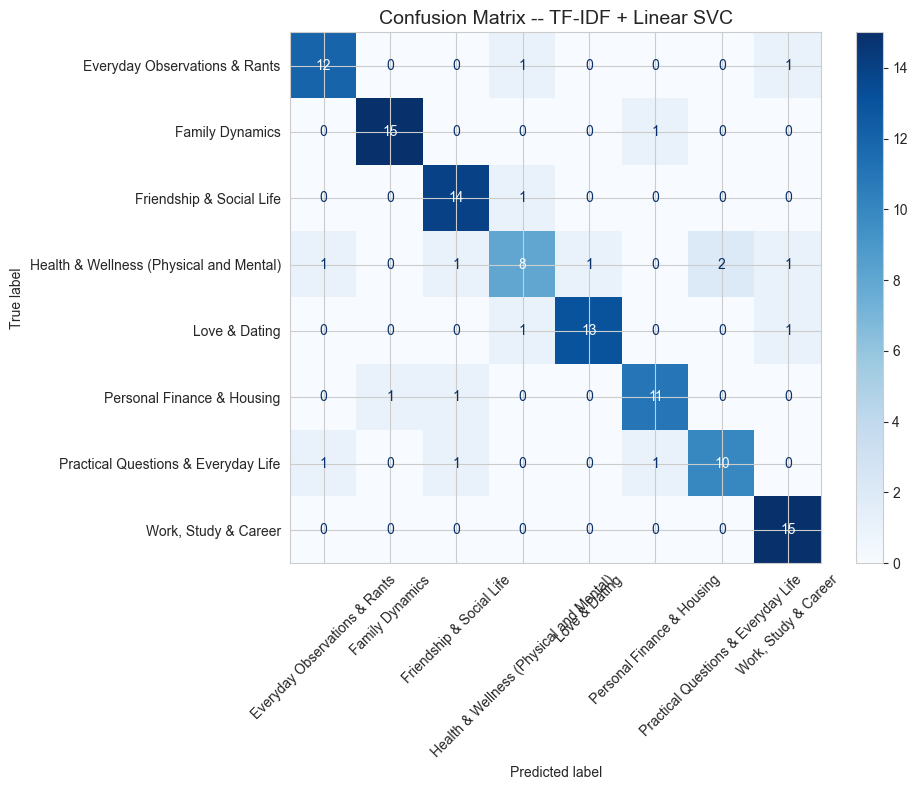

In [7]:
# ── Pick the better model for visualization ─────────────────────────
if acc_svc >= acc_lr:
    best_name = "Linear SVC"
    best_pred = y_pred_svc
else:
    best_name = "Logistic Regression"
    best_pred = y_pred_lr

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    best_pred,
    ax=ax,
    cmap="Blues",
    xticks_rotation=45,
)
ax.set_title(f"Confusion Matrix -- TF-IDF + {best_name}", fontsize=14)
plt.tight_layout()
plt.show()

## 7. Top Features per Class

One of the biggest advantages of linear models is **interpretability**. Both Logistic Regression and LinearSVC learn a coefficient vector for each class. The features with the **highest positive coefficients** are the ones most associated with predicting that class.

Let's extract the top-10 TF-IDF features for each of the 8 categories from the Logistic Regression model.

In [8]:
# ── Top 10 TF-IDF features per class (Logistic Regression) ──────────
vectorizer = pipe_lr.named_steps["tfidf"]
clf_lr = pipe_lr.named_steps["clf"]

feature_names = vectorizer.get_feature_names_out()
class_labels = clf_lr.classes_

top_n = 10
top_features = {}

for i, label in enumerate(class_labels):
    coef = clf_lr.coef_[i]
    top_idx = np.argsort(coef)[-top_n:][::-1]
    top_features[label] = [feature_names[j] for j in top_idx]

top_df = pd.DataFrame(top_features)
top_df.index = [f"#{r+1}" for r in range(top_n)]
top_df.index.name = "Rank"

# Display with transposed view for readability
print("Top 10 TF-IDF features per class (Logistic Regression)\n")
display(top_df.T)

Top 10 TF-IDF features per class (Logistic Regression)



Rank,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
Everyday Observations & Rants,people,stand,bus,leave,hard,people don,phone,cyclists,middle,lights
Family Dynamics,parents,family,sister,mom,dad,christmas,little sister,old,brother,mother
Friendship & Social Life,friend,group,friends,friendship,best friend,feel,friend started,chat,friend group,best
Health & Wellness (Physical and Mental),pain,sleep,hate,eat,skin,especially,stomach,dependent,swallowing,brain
Love & Dating,boyfriend,love,date,relationship,friends,guy,ex,cat,doesn like,wants
Personal Finance & Housing,money,buy,expensive,idea,kr,save,roommate,bad,apartment,bad idea
Practical Questions & Everyday Life,best,trick,works,remove,ideas,best way,actually,white,good ideas,machine
"Work, Study & Career",boss,job,class,teacher,afraid,study,feel,awkward,asks,time job


## 8. Error Analysis

Looking at aggregate metrics is not enough. **The most important skill in applied NLP is reading the errors.** By examining specific misclassified examples -- especially the ones the model was *most confident* about -- we can discover:

- Ambiguous or mislabelled data
- Overlapping categories that might need to be merged
- Systematic biases (e.g., certain keywords triggering the wrong class)

We use the Logistic Regression pipeline because it supports `predict_proba`, which gives us calibrated confidence scores.

In [9]:
# ── Error analysis with confidence scores ───────────────────────────
proba = pipe_lr.predict_proba(X_test)
pred_lr = pipe_lr.predict(X_test)

# Build a DataFrame of all test predictions
error_df = pd.DataFrame({
    "text": X_test.values,
    "true_label": y_test.values,
    "predicted_label": pred_lr,
    "confidence": proba.max(axis=1),
})

# Keep only the misclassified examples
errors = error_df[error_df["true_label"] != error_df["predicted_label"]].copy()
errors["text"] = errors["text"].str[:100] + "..."

# Sort by confidence descending -- the worst mistakes
errors = errors.sort_values("confidence", ascending=False)

print(f"Total test samples: {len(error_df)}")
print(f"Misclassified:      {len(errors)} ({len(errors)/len(error_df)*100:.1f}%)")
print()
print("── Top 5 most-confident wrong predictions ──\n")
display(errors.head(5))

Total test samples: 115
Misclassified:      18 (15.7%)

── Top 5 most-confident wrong predictions ──



,text,true_label,predicted_label,confidence
96,how much is reasonable to spend on a wedding g...,Personal Finance & Housing,Friendship & Social Life,0.244340
64,i think i'm allergic to my new job . shortly a...,Health & Wellness (Physical and Mental),"Work, Study & Career",0.223671
75,i always get an electric shock from everything...,Health & Wellness (Physical and Mental),Practical Questions & Everyday Life,0.199375
83,which air fryer should i choose? . the whole w...,Practical Questions & Everyday Life,Personal Finance & Housing,0.183860
3,i am afraid of missing out on things (fomo) . ...,Friendship & Social Life,Health & Wellness (Physical and Mental),0.181872


**What to look for in the errors above:**

- **High-confidence mistakes** often indicate label noise or genuinely ambiguous posts (e.g., a post about stress at work could be "Work, Study & Career" *or* "Health & Wellness").
- **Recurring confusions** between two categories suggest those categories may overlap in the dataset or that the model needs more discriminative features.
- If many errors share a keyword pattern, a custom feature or different preprocessing might help.

## 9. Summary & Takeaways

### Results

| Model | Accuracy |
|---|---|
| TF-IDF + Logistic Regression | see above |
| TF-IDF + Linear SVC | see above |

### When should you use TF-IDF + linear models?

- **Fast to train and predict** -- no GPU required, fits in seconds
- **Highly interpretable** -- you can inspect exactly which words drive each prediction
- **Excellent baseline** -- always start here before reaching for deep learning
- **Works well with small data** -- 457 samples is plenty for a linear model; a Transformer would likely overfit
- **Production-friendly** -- tiny model size, no external dependencies beyond scikit-learn

### What's next?

In **NB02** we will replace TF-IDF with **sentence embeddings** (SBERT) and see whether capturing semantic meaning improves classification. We will carry forward the same dataset, split, and evaluation setup so the comparison is fair.

In [10]:
# ── Results comparison ───────────────────────────────────────────────
results = {
    "TF-IDF + Logistic Regression": acc_lr,
    "TF-IDF + Linear SVC": acc_svc,
}

results_df = pd.DataFrame(
    list(results.items()),
    columns=["Model", "Accuracy"],
).sort_values("Accuracy", ascending=False)

print("── Model Comparison ──\n")
display(results_df.reset_index(drop=True))

# Store for re-use in NB02
print("\nResults dict (copy into NB02 for comparison):")
print(results)

── Model Comparison ──



,Model,Accuracy
0,TF-IDF + Linear SVC,0.852174
1,TF-IDF + Logistic Regression,0.843478



Results dict (copy into NB02 for comparison):
{'TF-IDF + Logistic Regression': 0.8434782608695652, 'TF-IDF + Linear SVC': 0.8521739130434782}
